# Comparing Mutual Information over Dimensionality

In this notebook, I'll compare mutual information estimates while varying degrees of dimensionality reduction. 

I'll only be using PCA in this notebook since its faster than MDS.

In [22]:
import os

import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition

import config
from confusion import ConfusionMatrix
from load import DataExplorer
from mutual_information import monte_carlo_mutual_information
from process_spikes import bin_spikes, conv, exponential_convolver
from fit_gaussians import fit_gaussians
from template import (
    compute_euclidian_distances_to_all_templates,
    compute_nearest_template_with_ties,
    template_selectors,
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
BIRD = "GreBlu9508M"
SITE = 2
UNIT = (21, 1)

In [3]:
dat = DataExplorer(
    config.DATADIR,
    BIRD,
    SITE,
    exclude_noise=True,
    exclude_song=True)

In [5]:
table, spike_times = dat.load_table(filter_unit=UNIT, load_spike_times=True)
_, spikes = bin_spikes(spike_times, min_time=config.MIN_TIME, max_time=config.MAX_TIME)
psths = conv(spikes, exponential_convolver, config.WIDTH)

### First, using decoding technique

Note: There are two parts of this that take a bit. The first is the dimensionality reduction. PCA is pretty fast, but MDS can take a while (and a lot of memory) if embedding into a high number of dimensions). Also, the decoding process (computing distances to templates) can take a while as well. It may be useful to pre-compute and save the reduced arrays as well as the confusion matrices so that you don't need to wait every time.

See the Confusion Matrix Demo notebook for details on this procedure.

In [13]:
DIMS = [1, 2, 3, 4, 6, 8, 10, 12, 14, 16, 24, 32]

In [16]:
info = []
info_ctrl = []

pca = sklearn.decomposition.PCA(n_components=max(DIMS))
x = pca.fit_transform(psths)

for dim in DIMS:
    # This is taking the first *dim* principal components. Can replace with MDS here
    x_arr = x[:, :dim]
    
    # Create a second array that shuffles all labels in order to view bias
    x_shuffle = np.copy(x_arr)
    np.random.shuffle(x_shuffle)
    
    selectors, stims = template_selectors(table)
    
    # Compute confusion matrix with the real data
    distances = compute_euclidian_distances_to_all_templates(x_arr, selectors)
    predicted = compute_nearest_template_with_ties(distances, stims)
    conf = ConfusionMatrix(table["stim"], predicted)
    
    # Compute confusion matrix on data with shuffled labels, *x_shuffle*
    distances_ctrl = compute_euclidian_distances_to_all_templates(x_shuffle, selectors)
    predicted_ctrl = compute_nearest_template_with_ties(distances_ctrl, stims)
    conf_ctrl = ConfusionMatrix(table["stim"], predicted_ctrl)

    info.append(conf.information())
    info_ctrl.append(conf_ctrl.information())
    print "finished", dim


finished 1
finished 2
finished 3
finished 4
finished 6
finished 8
finished 10
finished 12
finished 14
finished 16
finished 24
finished 32


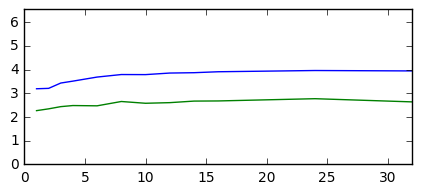

In [19]:
plt.figure(figsize=(5, 2))
plt.plot(DIMS, info)
plt.plot(DIMS, info_ctrl)
plt.ylim(0, np.log2(len(np.unique(table["stim"]))))
plt.xlim(0, max(DIMS))
plt.show()

### Next, using mixture of gaussians model and monte-carlo estimation

Since there are only about 10 trials per stimulus, we can't really fit high-dimensional gaussians to estimate $P(R|S)$. So I'll only go up to dimension 5.

Again, we will compute information for both the true data and the data with shuffled labels.

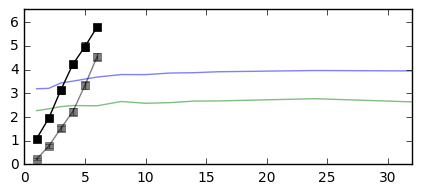

In [35]:
DIMS_2 = [1,2,3,4,5,6]

info_est = []
info_est_err = []
info_est_ctrl = []
info_est_ctrl_err = []
for dim in DIMS_2:
    # Take top *dim* PCs
    x_arr = x[:, :dim]
    
    # Create a second array that shuffles all labels in order to view bias
    x_shuffle = np.copy(x_arr)
    np.random.shuffle(x_shuffle)

    # Fit gaussians to responses grouped by stimulus
    dists, p = fit_gaussians(table, x_arr, key="stim")
    mutual_info, err = monte_carlo_mutual_information(dists, n=200)
    info_est.append(mutual_info)
    info_est_err.append(err)
    
    # Control case
    dists, p = fit_gaussians(table, x_shuffle, key="stim")
    mutual_info, err = monte_carlo_mutual_information(dists, n=200)
    info_est_ctrl.append(mutual_info)
    info_est_ctrl_err.append(err)

plt.figure(figsize=(5, 2))
plt.plot(DIMS, info, alpha=0.5, label="PCA")
plt.plot(DIMS, info_ctrl, alpha=0.5, label="PCA Control")
plt.errorbar(DIMS_2, info_est, yerr=info_est_err, color="k", label="Monte Carlo")
plt.errorbar(DIMS_2, info_est_ctrl, yerr=info_est_ctrl_err, alpha=0.5, color="k", label="MC Control")
plt.ylim(0, np.log2(len(np.unique(table["stim"]))))
plt.xlim(0, max(DIMS))
plt.show()

### Finally using the above with stimulus category instead of stimulus

Since there are only about 10 trials per stimulus, we can't really fit high-dimensional gaussians to estimate $P(R|S)$. So I'll only go up to dimension 5. By grouping by higher-level semantic category instead (i.e. aggressive, distance, etc), we have more datapoints per category and can presumably go up to higher numbers of dimensions.

Again, we will compute information for both the true data and the data with shuffled labels.

You'll find that the sampling bias seems to be pretty significant still.

In [36]:
info = []
info_ctrl = []

pca = sklearn.decomposition.PCA(n_components=max(DIMS))
x = pca.fit_transform(psths)

for dim in DIMS:
    x_arr = x[:, :dim]
    # Create a second array that shuffles all labels in order to view bias
    x_shuffle = np.copy(x_arr)
    np.random.shuffle(x_shuffle)
    
    selectors, stims = template_selectors(table, key="stim_type")
    
    distances = compute_euclidian_distances_to_all_templates(x_arr, selectors)
    predicted = compute_nearest_template_with_ties(distances, stims)
    conf = ConfusionMatrix(table["stim_type"], predicted)
    
    distances_ctrl = compute_euclidian_distances_to_all_templates(x_shuffle, selectors)
    predicted_ctrl = compute_nearest_template_with_ties(distances_ctrl, stims)
    conf_ctrl = ConfusionMatrix(table["stim_type"], predicted_ctrl)

    info.append(conf.information())
    info_ctrl.append(conf_ctrl.information())
    print "finished", dim


finished 1
finished 2
finished 3
finished 4
finished 6
finished 8
finished 10
finished 12
finished 14
finished 16
finished 24
finished 32


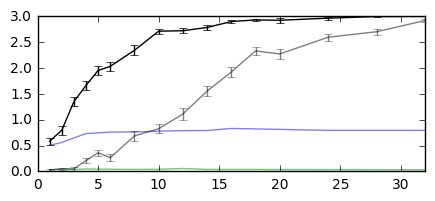

In [40]:
DIMS_2 = [1,2,3,4,5,6,8,10,12,14,16,18,20,24,28,32]

info_est = []
info_est_err = []
info_est_ctrl = []
info_est_ctrl_err = []
for dim in DIMS_2:
    x_arr = x[:, :dim]
    # Create a second array that shuffles all labels in order to view bias
    x_shuffle = np.copy(x_arr)
    np.random.shuffle(x_shuffle)

    dists, p = fit_gaussians(table, x_arr, key="stim_type")

    mutual_info, err = monte_carlo_mutual_information(dists, n=200)
    info_est.append(mutual_info)
    info_est_err.append(err)
    
    dists, p = fit_gaussians(table, x_shuffle, key="stim_type")
    mutual_info, err = monte_carlo_mutual_information(dists, n=200)
    info_est_ctrl.append(mutual_info)
    info_est_ctrl_err.append(err)


plt.figure(figsize=(5, 2))
plt.plot(DIMS, info, alpha=0.5)
plt.plot(DIMS, info_ctrl, alpha=0.5)
plt.errorbar(DIMS_2, info_est, yerr=info_est_err, color="k")
plt.errorbar(DIMS_2, info_est_ctrl, yerr=info_est_ctrl_err, alpha=0.5, color="k")
plt.ylim(0, np.log2(len(np.unique(table["stim_type"]))))
plt.xlim(0, max(DIMS))
plt.show()